In [1]:
import matplotlib.pylab as plt  
import pandas as pd
import numpy as np
import sympy as sy
import scipy as sc
from scipy.optimize import curve_fit


In [2]:
data_1 = pd.read_csv("data_1.csv", header=None, names=("phi", "I"), delimiter=r"\s+")
data_1.head()

,phi,I
0,5,94.1
1,10,92.6
2,15,88.4
3,20,79.0
4,25,70.6


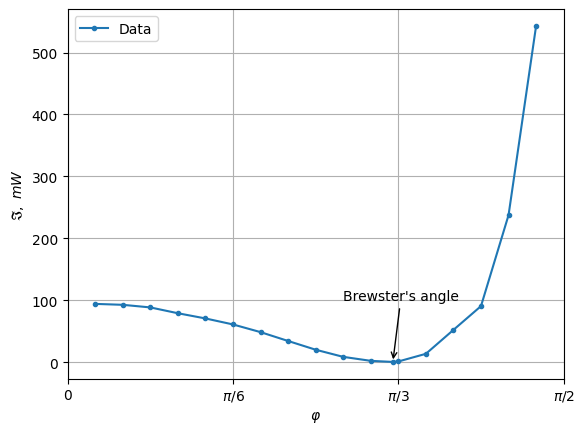

In [3]:
def fun(x, n_1, n_2):
    g = lambda x, n_1, n_2: np.sqrt(1-(n_1*np.sin(x)/n_2)**2)
    f = lambda x, n_1, n_2: ((n_2 * np.cos(x) - n_1 * g(x,n_1, n_2))/(n_2 * np.cos(x) + n_1 * g(x,n_1, n_2)))**2
    return 94/f(5*np.pi/180, n_1, n_2)*f(x, n_1, n_2)

phi_1, I_1 = data_1.to_numpy().T
phi_1 = phi_1/90*np.pi/2
phi = np.linspace(0, np.pi/2 - 5*np.pi/180, 100)
plt.plot(phi_1, I_1, '.-', label = "Data")
plt.ylabel("$\\mathfrak{I}, \ mW$")
plt.xlabel("$\\varphi$")
plt.xticks(
    np.linspace(0, np.pi/2, 4),
    [r'$0$',r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.grid("True")
plt.annotate("Brewster's angle", xy=(np.pi/3 - np.pi/180, 0), xytext=(np.pi/3 - 10*np.pi/180, 100),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.legend()
plt.savefig("Ex_2/Task_2_1_1.png")
plt.show()


In [4]:
def decor_arg(deriv):
    def decor(func):        
        def wrapper(x, n_1, n_2, par = 's', norm = True):
            g = np.sqrt(1-(n_1*np.sin(x)/n_2)**2)
            if norm:
                if par == 's':
                    c_norm = func(5*np.pi/180, g, n_1, n_2)/94.1
                else:
                    c_norm = func(5*np.pi/180, g, n_2, n_1)/46.2
            else:
                c_norm = 1
            if par == 'p':
                if deriv:
                    return func(x, g, n_1, n_2)/c_norm
                return func(x, g, n_2, n_1)/c_norm
            if par == 's':
                return func(x, g, n_1, n_2)/c_norm
        return wrapper
    return decor

@decor_arg(deriv = False)
def fun(x, g, n_1, n_2): 
    return ((n_2 * np.cos(x) - n_1 * g)/(n_2 * np.cos(x) + n_1 * g))**2
@decor_arg(deriv = True)
def df_n1_s (x, g, n_1, n_2):
    return 4*g*n_2*np.cos(x) * (n_1*g - n_2*np.cos(x)) / (n_1*g + n_2*np.cos(x))**3
@decor_arg(deriv = True)
def df_n2_s (x, g, n_1, n_2): 
    return 4*g*n_1*np.cos(x) * (n_2*np.cos(x) - n_1*g) / (n_1*g + n_2*np.cos(x))**3
@decor_arg(deriv = True)
def df_n2_p (x, g, n_2, n_1):
    return 4*g*n_2*np.cos(x) * (n_1*g - n_2*np.cos(x)) / (n_1*g + n_2*np.cos(x))**3
@decor_arg(deriv = True)
def df_n1_p (x, g, n_2, n_1): 
    return 4*g*n_1*np.cos(x) * (n_2*np.cos(x) - n_1*g) / (n_1*g + n_2*np.cos(x))**3

f = lambda z, n_1, n_2: np.array([fun(i, n_1, n_2) for i in z], dtype = float)
j = lambda z, n_1, n_2: np.array([[df_n1_s(i, n_1, n_2),df_n2_s(i, n_1, n_2)] for i in z], dtype = float)


In [5]:
def lm(y, f, j, x0, lmbd0=1e-2, nu=2, tol=1e-4):
    dxf = lambda g, JJ, l=0: np.linalg.inv(JJ + l * np.eye(int((JJ).size ** 0.5))) @ g
    norm = lambda x: 1/2 * np.linalg.norm(x, ord = 2)**2
    t = 0; cost = []; dx = tol; diff = dx + 1; x0 = np.asarray(x0, dtype=np.float64)
    while diff > tol and t <= 200:
        r = y - f(*x0); J = j(*x0); g = J.T @ r; JJ = J.T @ J
        dx_n = dxf(g, JJ, lmbd0/nu)
        r1 = y - f(*(x0 + dx))
        if norm(r1) <= norm(r):
            lmbd0 /= nu 
            dx = dx_n
            x0 += dx
        else:
            dx_n = dxf(g, JJ, lmbd0)
            r1 = y - f(*(x0 + dx))
            if norm(r1) <= norm(r):
                dx = dx_n
                x0 += dx            
            else:
                while norm(r1) > norm(r):
                    lmbd0 *= nu
                    dx = dx_n = dxf(g, JJ, lmbd0)
                    r1 = y - f(*(x0 + dx))
                r = r1
                x0 += dx
        cost.append(norm(r1))
        diff = np.linalg.norm(dx, ord = 2)
        t = t + 1 
    return x0

In [6]:
H_ = 1; Omega_ = 1.5
res_lm = lm(I_1[:-3], lambda x1, x2: f(phi_1[:-3], x1, x2), lambda x1, x2: j(phi_1[:-3], x1, x2), np.array([H_, Omega_]))
res_lm

array([1. , 1.5])

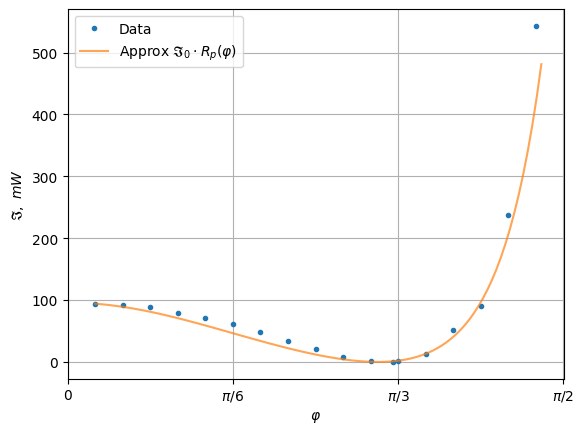

In [7]:
phi_1, I_1 = data_1.to_numpy().T
phi_1 = phi_1/90*np.pi/2
phi = np.linspace(5*np.pi/180, np.pi/2 - 4*np.pi/180, 100)
phi = phi.astype(np.float128)
plt.plot(phi_1, I_1, '.', label = "Data")
plt.plot(phi, fun(phi, *res_lm), '-', alpha = 0.7, label = "Approx $\\mathfrak{I}_0 \\cdot R_p\\left(\\varphi \\right)$")
plt.ylabel("$\\mathfrak{I}, \ mW$")
plt.xlabel("$\\varphi$")
plt.xticks(
    np.linspace(0, np.pi/2, 4),
    [r'$0$',r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.grid("True")
plt.legend()
plt.savefig("Ex_2/Task_2_1_2.png")
plt.show()

In [8]:
def gauss_newton(y, f, j, x0, k=1, tol=1e-4):
    dxf = lambda g, JJ, l=0: np.linalg.inv(JJ + l * np.eye(int((JJ).size ** 0.5))) @ g
    norm = lambda x: 1/2 * np.linalg.norm(x, ord = 2)**2
    t = 0
    diff = tol + 1
    cost = []
    while diff > tol and t <= 200:
        J = j(*x0); JJ = J.T@J; g = J.T@(y - f(*x0))
        p = np.linalg.pinv(j(*x0))
        dx_n = k*dxf(g, JJ)
        diff = np.linalg.norm(dx_n, ord = 2)
        x0 = dx_n + x0
        t = t + 1
        cost.append(norm(y - f(*(x0 + dx_n))))
    return x0

In [9]:
data_2 = pd.read_csv("data_2.csv", header=None, names=("phi", "I"), delimiter=r"\s+")
phi_2, I_2 = data_2.to_numpy().T
phi_2 = (phi_2 - 2)/90*np.pi/2
phi = np.linspace(5*np.pi/180, np.pi/2 - 10*np.pi/180, 100)


In [10]:
H_ = 1.01; Omega_ = 1.93
f = lambda z, n_1, n_2: np.array([fun(i, n_1, n_2, par='p') for i in z], dtype = float)
j = lambda z, n_1, n_2: np.array([[df_n1_p(i, n_1, n_2),df_n2_p(i, n_1, n_2, par='p')] for i in z], dtype = float)
res_lm = lm(I_2, lambda x1, x2: f(phi_2, x1, x2), lambda x1, x2: j(phi_2, x1, x2), np.array([H_, Omega_]), lmbd0=0.001, nu = 1.01)
np.abs(res_lm%np.pi)

array([1.01, 1.93])

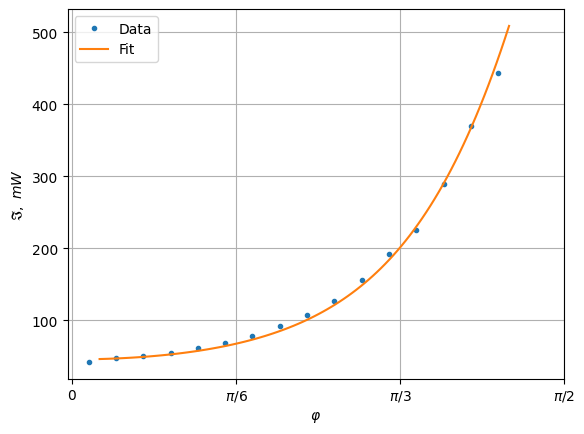

In [11]:
plt.plot(phi_2, I_2, '.', label = "Data")
plt.plot(phi, fun(phi, *np.abs(res_lm%np.pi), par = 'p'), '-',  label = "Fit")
plt.ylabel("$\\mathfrak{I}, \ mW$")
plt.xlabel("$\\varphi$")
plt.xticks(
    np.linspace(0, np.pi/2, 4),
    [r'$0$',r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.grid("True")
plt.legend()
plt.savefig("Ex_2/Task_2_2_1.png")
plt.show()

In [12]:
data_3 = pd.read_csv("data_f_1.csv", header=None, names=("phi", "I"), delimiter=r"\s+")
phi_3, I_3 = data_3.to_numpy().T
phi_3 = phi_3/90*np.pi/2
print(phi_3)

[0.         0.17453293 0.34906585 0.52359878 0.6981317  0.87266463
 1.04719755 1.22173048 1.3962634  1.57079633]


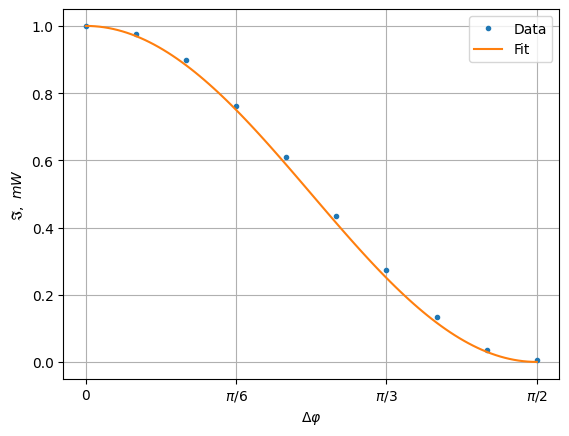

In [13]:
plt.plot(phi_3, I_3/I_3[0], '.', label = "Data")
phi = np.linspace(0, np.pi/2, 100)
plt.plot(phi, np.cos(phi)**2, '-', label = "Fit")
plt.xticks(
    np.linspace(0, np.pi/2, 4),
    [r'$0$',r'$\pi/6$', r'$\pi/3$', r'$\pi/2$'])
plt.grid("True")
plt.ylabel("$\\mathfrak{I}, \ mW$")
plt.xlabel("$\\Delta\\varphi$")
plt.legend()
plt.savefig("Ex_1/Task_1_1.png")
plt.show()

In [1]:
import os
for root, dirs, files in os.walk("."):  
    for filename in files:
        if ".hist" in filename:
            os.system(f"h2root {filename}")
            os.system(f".q")


FOPF.png
Lab_2.tex
Title.tex
Lab_2.pdf
Lab_2.auxlock
data_1.csv
code.ipynb
data_2.csv
.~lock.data_f_1.csv#
data_f_1.csv
Lab_2.aux
Lab_2.fdb_latexmk
Lab_2.log
Lab_2.out
Lab_2.toc
Lab_2.fls
Lab_2.synctex.gz
Ex_1.tex
Ex_1.aux
Task_1_1.png
Ex_2.aux
Ex_2.tex
Task_2_1_1.png
Task_2_1_2.png
Task_2_2_1.png
